In [262]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib 
from scipy.signal import savgol_filter
from numba import njit 
import pandas as pd
from scipy.stats import gamma
import ruptures as rpt
from scipy.optimize import curve_fit

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 19

In [2]:
def compute_sd(traj):      
    x = traj['x (micron)'].values
    y = traj['y (micron)'].values
    x0 = x[0]
    y0 = y[0]
    return np.sqrt( (x-x0)**2 + (y-y0)**2)

In [357]:
import re 

def extract_in_pair_intervals(obs_str):
    intervals = []
    
    # Case: 'In pairs until frame 114'
    match = re.search(r'In pairs until frame (\d+)', obs_str)
    if match:
        end = int(match.group(1))
        intervals.append((0, end))

    # Case: 'In pairs between frames 78 and 139'
    matches = re.findall(r'In pairs between frames (\d+) and (\d+)', obs_str)
    for start, end in matches:
        intervals.append((int(start), int(end)))

    # Case: 'Not in pairs between frames 7 and 32, and frames 141 and 175'
    # => we infer 'in pairs' as complement
    not_in_pairs = re.findall(r'frames (\d+) and (\d+)', obs_str)
    if 'Not in pairs' in obs_str and not_in_pairs:
        not_intervals = [(int(start), int(end)) for start, end in not_in_pairs]
        # Assume a global time range if needed (you can pass this in)
        min_frame, max_frame = 0, 10**6
        # Compute complement
        current = min_frame
        for start, end in sorted(not_intervals):
            if current < start:
                intervals.append((current, start - 1))
            current = end + 1
        if current <= max_frame:
            intervals.append((current, max_frame))

    return intervals
def is_in_pair(frame, obs_str):
    intervals = extract_in_pair_intervals(obs_str)
    return any(start <= frame <= end for start, end in intervals)

In [265]:

def piecewise_gamma(x, x0, y0, k, theta):
    """
    Piecewise function:
    - Returns y0 for x <= x0
    - Follows a Gamma distribution for x > x0
    
    Parameters:
    x : float or array-like
        Input value(s)
    x0 : float
        Threshold value
    y0 : float
        Fixed value for x <= x0
    k : float
        Shape parameter of the Gamma distribution
    theta : float
        Scale parameter of the Gamma distribution
    
    Returns:
    float or array-like: Evaluated function values
    """
    x = np.asarray(x)  # Ensure x is an array for vectorized operations
    gamma_values = gamma.pdf(x - x0, a=k, scale=theta)  # Gamma PDF shifted by x0
    return np.where(x < x0, y0, gamma_values)



def mean_piecewise(x0, y0, k, theta, a, b):
    """
    Computes the mean of the piecewise function over [a, b].

    Parameters:
    x0 : float
        Threshold separating constant and gamma regions
    y0 : float
        Fixed value for x <= x0
    k : float
        Shape parameter of the Gamma distribution
    theta : float
        Scale parameter of the Gamma distribution
    a, b : float
        Integration limits
    
    Returns:
    float: Mean of the function over [a, b]
    """
    # Constant region integral
    I1 = y0 * (x0 - a)

    # Gamma region integral (expectation of the gamma pdf)
    gamma_mean = k * theta  # Mean of Gamma distribution
    I2 = gamma.cdf(b - x0, a=k, scale=theta) * gamma_mean

    # Compute mean
    return (I1 + I2) / (b - a)

In [308]:
def plot_piece_wise_and_gamma(data, x0_guess, k_guess, theta_guess, variable, title, plot_title=False):
    fig, ax = plt.subplots(figsize=(4, 4))

    a = np.array(data)
   

    # Histogram and gamma fit on non-zero data
    freq, bins = np.histogram(a, bins=80, density=True)
    x = np.linspace(0, max(data), 500)
    
    

    # Fit piecewise gamma
    pw_params, pw_cov = curve_fit(piecewise_gamma, bins[:-1], freq, p0=[x0_guess, max(freq), k_guess, theta_guess])
    x0, y0, k, theta = pw_params
    mean_value = mean_piecewise(x0, y0, k, theta, 0, max(data))

    # Histogram again (to reuse bins for plotting)
    
   
    # Plot histogram and fits
    ax.hist(data, bins=len(bins), label=f'avg = {np.mean(data):.3f}', color='blue', density=True)
    ax.plot(x, piecewise_gamma(x, *pw_params), ls='--', c='black', lw=1.2,
            label=f'x0 = {x0:.3f},\n scale = {theta:.3f},\n shape = {k:.3f},\n avg fit = {mean_value:.3f}')
    
    # Vertical lines
    

    # Labels and legend
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=10)

    if plot_title:
        fig.suptitle(title, fontsize=15, y=0.9)

    plt.tight_layout()
    plt.show()

    return np.mean(data)

In [181]:
def linear_fit(x,a,b):
    return a*x +b

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid',) / w

In [4]:
dataframe_isolated = pd.read_csv('data/group-trajectories/second_wave/isolated_pairs_video1_v3_wspeeds.csv',index_col = 0)
ids_isolated = dataframe_isolated['Track ID'].unique()
all_speeds_isolated = []
computed_ids_isolated = []
for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        computed_ids_isolated.append(id)
dataframe_isolated

,Track ID,x (micron),y (micron),t (sec),Frame,Info,Obs,vx,vy,speed
Spot ID,,,,,,,,,,
2001,0,32.908503,33.861253,0.000000,0,Isolated,No obs,0.000000,0.000000,0.000000
2064,0,32.882753,33.887003,3.334563,1,Isolated,No obs,-0.007721,0.007721,0.010919
2068,0,32.779753,33.475003,6.669126,2,Isolated,No obs,-0.030885,-0.123538,0.127340
2071,0,32.728253,33.063003,10.003688,3,Isolated,No obs,-0.015442,-0.123538,0.124500
2073,0,32.857003,33.217503,13.338251,4,Isolated,No obs,0.038606,0.046327,0.060304
...,...,...,...,...,...,...,...,...,...,...
17599,18,76.820840,47.225504,650.239749,195,Pairs,In pairs between frames 78 and 139,-0.077211,-0.010295,0.077895
17601,18,76.923840,47.174004,653.574312,196,Pairs,In pairs between frames 78 and 139,0.030885,-0.015442,0.034530
17603,18,77.061174,47.105338,656.908874,197,Pairs,In pairs between frames 78 and 139,0.041179,-0.020590,0.046040


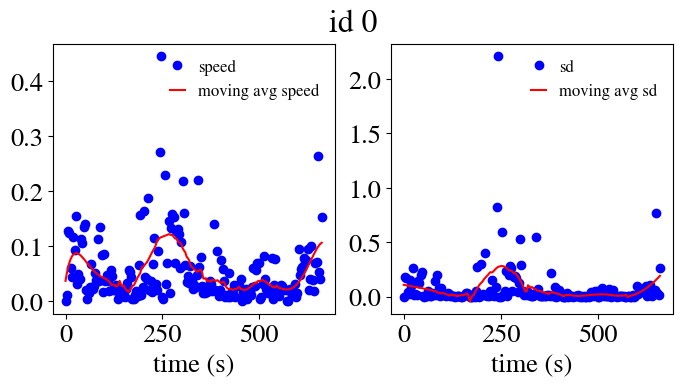

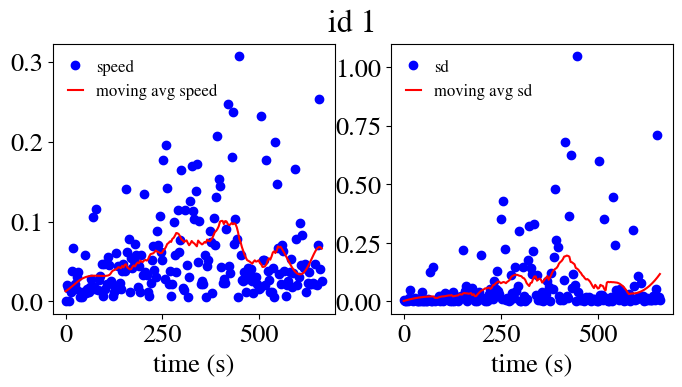

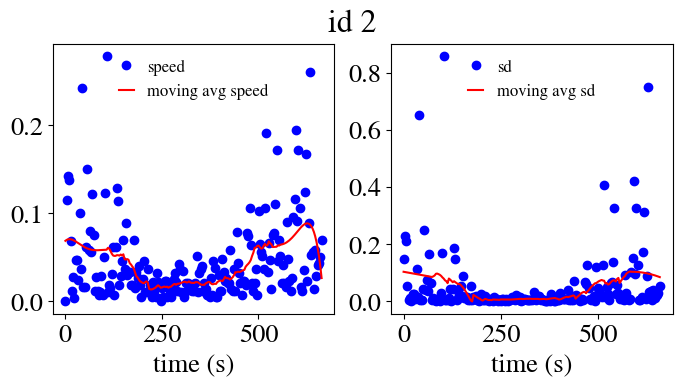

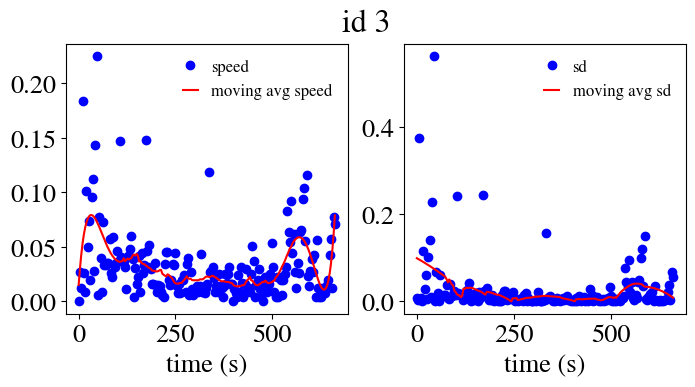

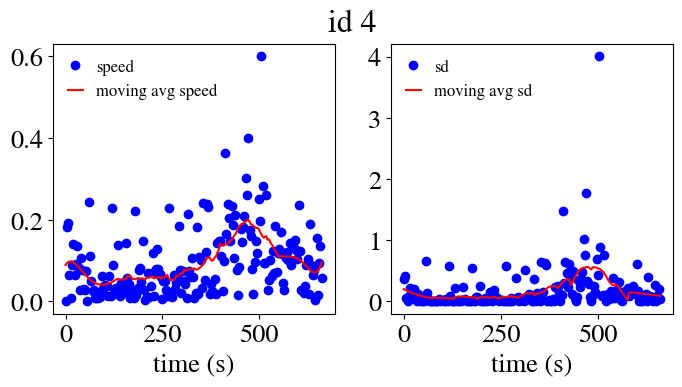

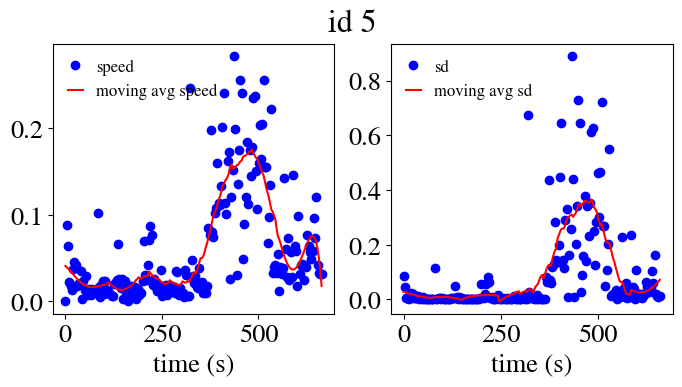

In [349]:
all_speeds_smooths = []
all_speeds = []
for id in computed_ids_isolated[:]:
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    # sd = compute_sd(traj)
    x = traj['x (micron)'].values
    y = traj['y (micron)'].values
    sd = np.diff(x)**2 + np.diff(y)**2
    time = traj['t (sec)'].values
    speed = traj['speed'].values
    # sd_smooth = moving_average(sd,4)

    window_sd = 45
    order_sd = 2
    window_speed = 65
    order_speed = 5
    sd_smooth = savgol_filter(sd,window_sd,order_sd)

    speed_smooth = savgol_filter(speed,window_speed,order_speed) 
    plt.figure(figsize=(8,3.5))
    plt.suptitle(f'id {id}')
    plt.subplot(1,2,1)
    
    plt.plot(time,speed,'bo',label='speed')
    plt.plot(time,speed_smooth,lw=1.5,color='red',label='moving avg speed')
    plt.legend(fontsize=12,handlelength=0.9,frameon=False)
    # plt.figure(figsize=(4,4))
    # # plt.title(f'window = {window}',fontsize=14)
    plt.xlabel('time (s)')
    plt.subplot(1,2,2)
    plt.plot(time[:-1],sd,'bo',label='sd')
    plt.plot(time[:-1],sd_smooth,lw=1.5,color='red',label='moving avg sd')
    plt.legend(fontsize=12,handlelength=0.9,frameon=False)
    plt.xlabel('time (s)')
    plt.show()
    all_speeds_smooths += list(speed_smooth)
    all_speeds += list(speed)
    

    

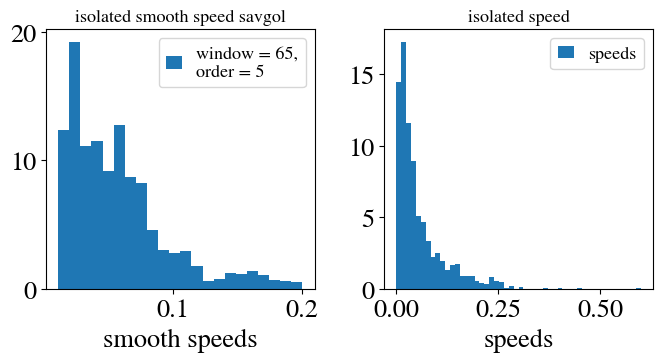

In [119]:
plt.figure(figsize=(7,4),layout='tight')
plt.subplot(1,2,1)

plt.hist(all_speeds_smooths,label=f'window = {window_speed},\norder = {order_speed}',bins='auto',density=True)
plt.xlabel('smooth speeds')
plt.title('isolated smooth speed savgol',fontsize=13)
plt.legend(fontsize=13,handlelength=0.9,frameon=True)
# plt.semilogy()
plt.subplot(1,2,2)

plt.hist(all_speeds,label='speeds',bins=50,density=True)
plt.xlabel('speeds')
plt.title('isolated speed',fontsize=13)
plt.legend(fontsize=13,handlelength=0.9,frameon=True)
# plt.semilogy()
plt.show()

In [553]:
from ruptures.base import BaseCost

class CostLinear(BaseCost):
    """Custom cost: piecewise linear fit (least squares error)."""

    model = "linear"
    min_size = 2  # Add this line!

    def fit(self, signal):
        self.signal = np.array(signal)
        return self

    def error(self, start, end):
        y = self.signal[start:end]
        x = np.arange(end - start)

        if len(y) < 2:  # prevent degenerate cases
            return 0

        # Fit a line: y = ax + b
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        y_fit = a * x + b
        error = np.sum((y - y_fit)**2)
        return error

    def cost(self, start, end):
        return self.error(start, end)

In [608]:
def slopes_compute(data,time,result,n,x,y):
    nbkp = len(result)
    slopes_list = np.zeros((nbkp,2))
    regions = np.zeros((nbkp,2),dtype=int)
    disp_in_regions = np.zeros(nbkp)
    for i in range(nbkp):
        
        if i == 0:
            start = 0
            # end = result[i+1]
        else:
            
            start = result[i-1]
        if result[i] == n:
            end = n-1
        else:
            end = result[i]
        dx = x[end] - x[start]
        dy = y[end] - y[start]
        disp = np.sqrt(dx**2 + dy**2)
        disp_in_regions[i] = disp

    
        regions[i] =np.array([start,end])
        params,_ = curve_fit(linear_fit,time[start+3:end-1],data[start+3:end-1])
        # slope = (sd[end]-sd[start])/(time[end]-time[start])
    
        slopes_list[i] = np.array([params[0],params[1]])
    return slopes_list,regions,disp_in_regions

In [626]:
def find_plateaus_runs(traj,id,obs,smooth=False,piecewise_linear=False):
    time = traj['Frame'].values
    x = traj['x (micron)'].values
    y = traj['y (micron)'].values
    sd = compute_sd(traj)
    window_sd = 33
    order_sd = 2
    if smooth:
        data = savgol_filter(sd,window_sd,order_sd)
    else:
        data = sd
    n = len(data)

    # Estimate noise by fitting one global line:
    coeffs = np.polyfit(np.arange(n), data, 1)
    resid  = data - np.polyval(coeffs, np.arange(n))
    sigma2 = np.var(resid)
    pen = sigma2 * np.log(n)
    if piecewise_linear:
        alg = rpt.Pelt(model="l2",min_size=15,jump=1).fit(data)
    else:
        cost = CostLinear().fit(data)
        alg = rpt.Pelt(custom_cost=cost, min_size=12, jump=1).fit(data)

    result= alg.predict(pen=pen*0.6)

    slopes_list,regions,disp_in_regions = slopes_compute(data,time,result,n,x,y)
    
    fig,ax = rpt.display(data, result,figsize=(4,4),alpha=0.9)
    ax[0].set_xlabel('time (frames)')
    ax[0].set_ylabel('SD')
    
    for i in range(len(result)):
        # print(i)
        start,end = regions[i][0],regions[i][1]
        slope,b = slopes_list[i][0],slopes_list[i][1]
        half_x = (end + start)//2
        # print(half_x)
        x = time[start:end]
        y = linear_fit(x,slope,b)
        # print(x)
        

        ax[0].plot(x,y,label=fr'$\Delta r$ = {disp_in_regions[i]:.3f}',alpha=0.8)
        ax[0].annotate(f'{slope:.4f}',xy=(half_x-1,data[half_x]+0.1),fontsize=12)
    ax[0].legend(fontsize=9,handlelength=0.8,frameon=False)
    ax[0].set_title(f'id {id}\n{obs}',fontsize=15)
    ax[0].set_xticks(result)
    ax[0].set_xticklabels(result,fontsize=10)

    
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(4,4))
    plt.scatter(slopes_list[:,0],disp_in_regions,s=20,color='red')
    plt.xlabel('slopes')
    plt.ylabel('displacements in regions')
    plt.title(f'id {id}',fontsize=13)
    plt.show()
    return slopes_list[:,0],disp_in_regions
    

In [356]:
traj = dataframe_isolated[dataframe_isolated['Track ID']==5].sort_values('Frame')
traj['Obs']

Spot ID
4986    Collision between frames 117 and 160
4988    Collision between frames 117 and 160
4990    Collision between frames 117 and 160
4992    Collision between frames 117 and 160
4994    Collision between frames 117 and 160
                        ...                 
5586    Collision between frames 117 and 160
5594    Collision between frames 117 and 160
5596    Collision between frames 117 and 160
5600    Collision between frames 117 and 160
5602    Collision between frames 117 and 160
Name: Obs, Length: 200, dtype: object

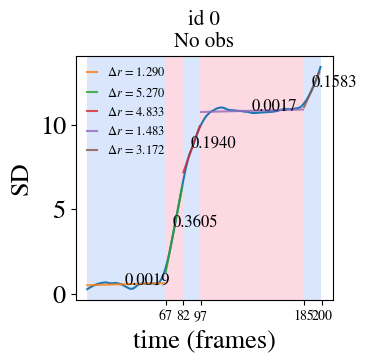

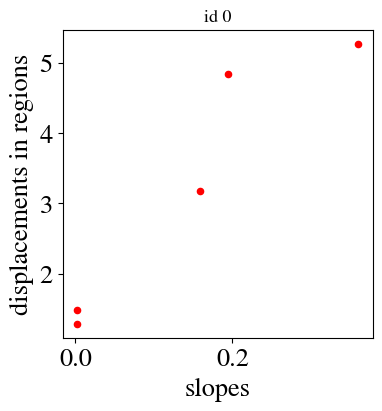

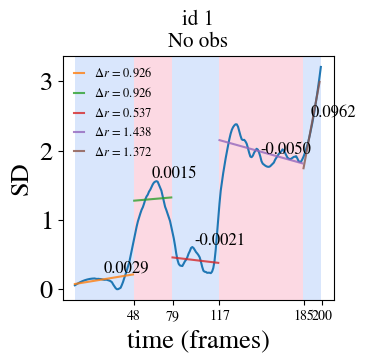

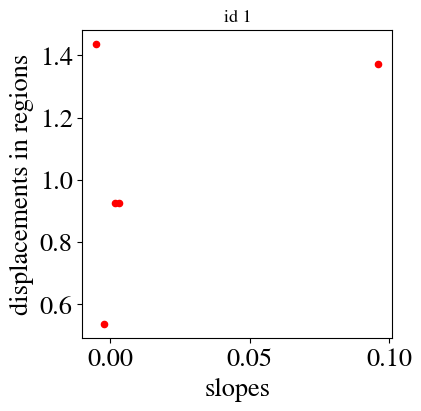

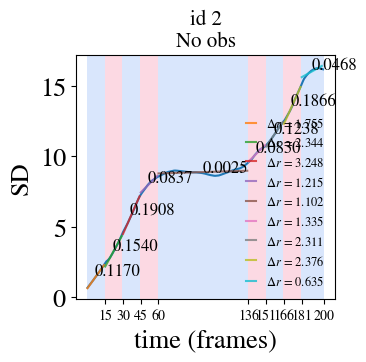

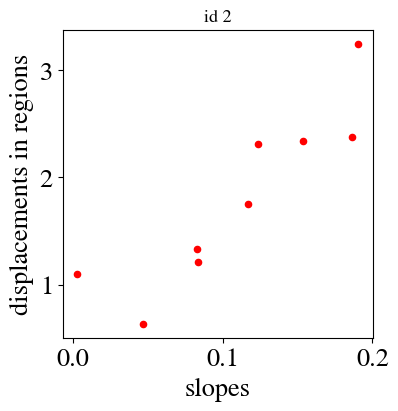

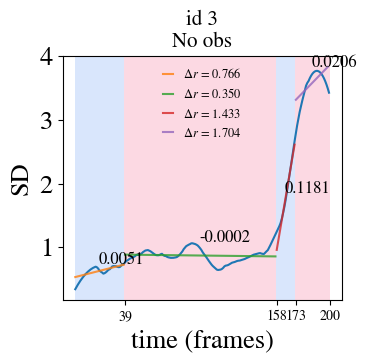

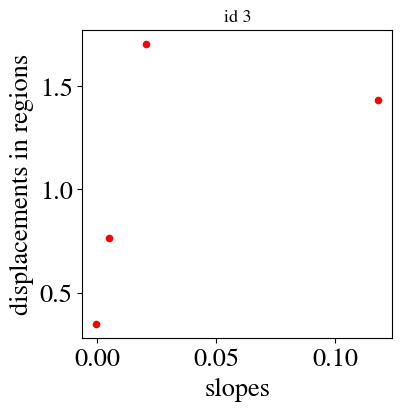

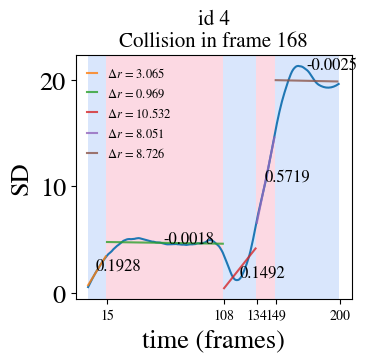

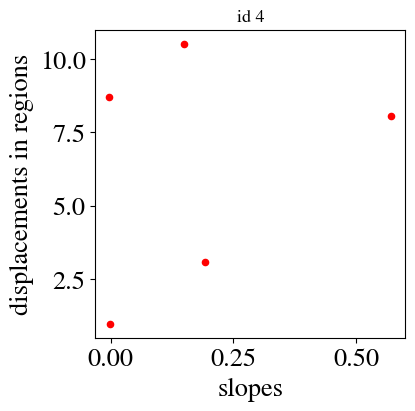

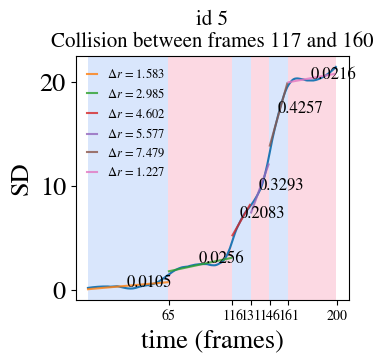

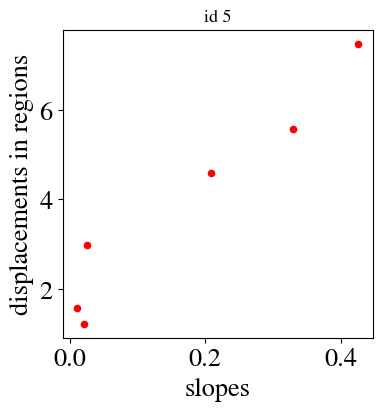

In [627]:
all_slopes_sd_isolated = []
all_disp_regions_isolated = []
for id in computed_ids_isolated:
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    obs = traj['Obs'].values[0]
    slopes_list,disp_in_regions=find_plateaus_runs(traj,id,obs,smooth=True,piecewise_linear=True)
    mask = slopes_list <= 0.2
    
    all_slopes_sd_isolated+=list(slopes_list[mask])
    all_disp_regions_isolated += list(disp_in_regions[mask])
    

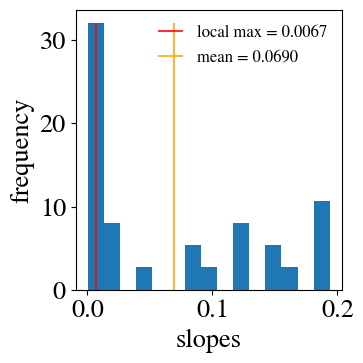

In [631]:
data = np.abs(all_slopes_sd_isolated) 
# data = data[data <= 0.2]
plt.figure(figsize=(4,4),layout='tight')
f = plt.hist(data,bins=15,density=True)
freq,bins = f[0],f[1]
bin_center = 0.5*(bins[1:] + bins[:-1])
max_prob = max(freq)
bin_max = bin_center[freq == max_prob][0]
plt.vlines(bin_max,0,max(freq),lw = 1.5,color='red',alpha = 0.8,label = f'local max = {bin_max:.4f}')
plt.vlines(np.mean(data),0,max(freq),lw = 1.5,color='orange',alpha = 0.8,label = f'mean = {np.mean(data):.4f}')
plt.xlabel('slopes')
plt.ylabel('frequency')
plt.legend(fontsize=12,handlelength=1.5,frameon=False)
# plt.semilogy()
plt.show()

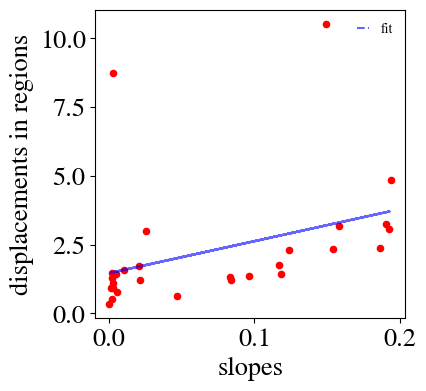

f(x) = ax + b
a = 11.642, b = 1.461


In [612]:
plt.figure(figsize=(4,4))
mask = data <= 0.2
x = data[mask]
y = np.array(all_disp_regions_isolated)[mask]
pcov,perr = curve_fit(linear_fit,x,y)
plt.scatter(x,y,s=20,color='red')
plt.plot(x,linear_fit(x,*pcov),label='fit',color='blue',lw=1.5, ls='--',alpha=0.6)
# label = f'y = ax + b\na = {pcov[0]:.3f}, b = {pcov[1]:.3f}'
plt.xlabel('slopes')
plt.ylabel('displacements in regions')
plt.legend(fontsize=10,handlelength=0.9,frameon=False)
# plt.loglog()
plt.show()
print(f'f(x) = ax + b\na = {pcov[0]:.3f}, b = {pcov[1]:.3f}')

In [680]:
id = 4
traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
x = traj['x (micron)'].values
y = traj['y (micron)'].values
speed = traj['speed'].values
time = traj['Frame'].values
sd = compute_sd(traj)

window_sd = 31
order_sd = 2
# sd_smooth = savgol_filter(sd,window_sd,order_sd)
n = len(sd)

cost = CostLinear().fit(sd)
# Estimate noise by fitting one global line:
coeffs = np.polyfit(np.arange(n), sd, 1)
resid  = sd - np.polyval(coeffs, np.arange(n))
sigma2 = np.var(resid)
pen = sigma2 * np.log(n)
alg = rpt.Pelt(custom_cost=cost, min_size=5, jump=1).fit(sd)
result= alg.predict(pen=pen*0.5)
nbkp = len(result)

In [681]:
slopes_list = np.zeros((nbkp,2))
regions = np.zeros((nbkp,2),dtype=int)
disp_in_regions = np.zeros(nbkp)
for i in range(len(result)):
    
    if i == 0:
        start = 0
        # end = result[i+1]
    else:
        
        start = result[i-1]
    if result[i] == n:
        end = n-1
    else:
        end = result[i]
    print(f'region [{start},{end}]')
    dx = x[end] - x[start]
    dy = y[end] - y[start]
    disp = np.sqrt(dx**2 + dy**2)
    disp_in_regions[i] = disp
    
    
    regions[i] =np.array([start,end])
    params,perr = curve_fit(linear_fit,time[start:end],sd[start:end])
    slope = params[0]
    # slope = (sd[end]-sd[start])/(time[end]-time[start])
    print(f'slope = {slope:.4f}\ndisp = {disp:.4f}\n--------------------------\n')
    # slopes_list.append([params[0],params[1]])

    slopes_list[i] = np.array([params[0],params[1]])

region [0,31]
slope = 0.1435
disp = 5.1017
--------------------------

region [31,118]
slope = -0.0218
disp = 4.0381
--------------------------

region [118,162]
slope = 0.5180
disp = 21.1739
--------------------------

region [162,199]
slope = -0.0700
disp = 5.8541
--------------------------



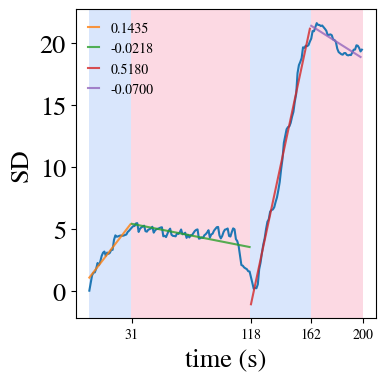

In [682]:
fig,ax = rpt.display(sd, result,figsize=(4,4))
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('SD')
for i in range(len(result)):
    start,end = regions[i][0],regions[i][1]
    slope,b = slopes_list[i][0],slopes_list[i][1]
    x = time[start:end]
    y = linear_fit(x,slope,b)
    
    # print(x)
    

    ax[0].plot(x,y,label=f'{slope:.4f}',alpha=0.8)
ax[0].legend(fontsize=10,handlelength=0.8,frameon=False)

ax[0].set_xticks(result)
ax[0].set_xticklabels(result,fontsize=10)

plt.show()

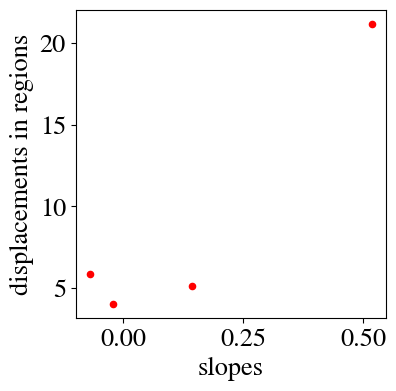

In [683]:
plt.figure(figsize=(4,4))
plt.scatter(slopes_list[:,0],disp_in_regions,s=20,color='red')
plt.xlabel('slopes')
plt.ylabel('displacements in regions')
plt.show()

Trying change-point identification with speed

pen = 0.1


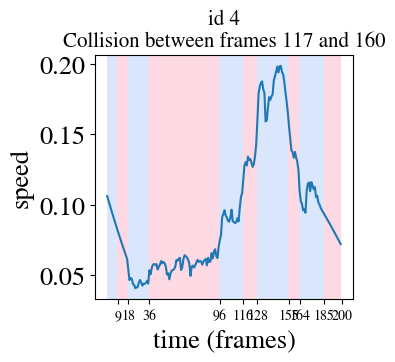

pen = 0.2


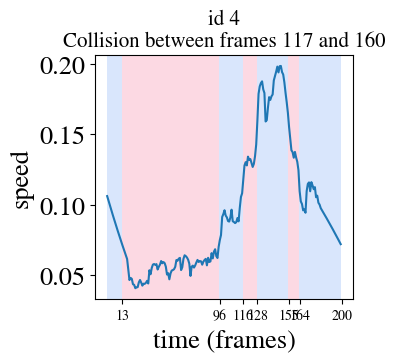

pen = 0.3


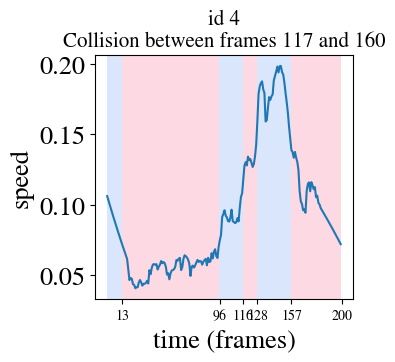

pen = 0.4


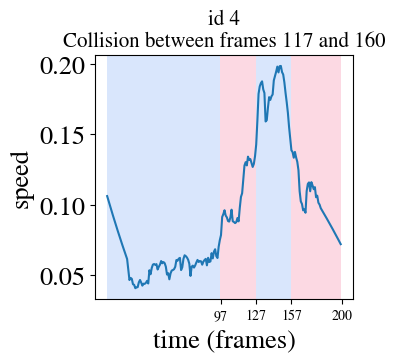

pen = 0.5


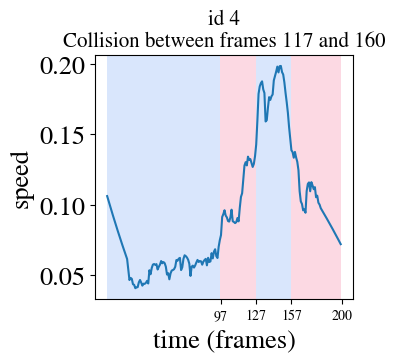

In [684]:
# speed_smooth = speed
window_sd = 35
order_sd = 2
speed_smooth =savgol_filter(speed,window_sd,order_sd)
n = len(speed_smooth)

# Estimate noise by fitting one global line:
# coeffs = np.polyfit(np.arange(n), speed_smooth, 1)
# resid  = sd - np.polyval(coeffs, np.arange(n))
# sigma2 = np.var(resid)
for pen in [0.1,0.2,0.3,0.4,0.5]:
    print(f'pen = {pen}')
    alg = rpt.Pelt(model="l1",min_size=1,jump=1).fit(speed_smooth)
    result= alg.predict(pen=pen)
    fig,ax = rpt.display(speed_smooth, result,figsize=(4,4))
    ax[0].set_xlabel('time (frames)')
    ax[0].set_ylabel('speed')

    ax[0].set_title(f'id {id}\n{obs}',fontsize=15)
    ax[0].set_xticks(result)
    ax[0].set_xticklabels(result,fontsize=10)
    plt.tight_layout()
    plt.show()
